开始运行[积分法修正]的非自治混沌实验，目标迭代: 10000000...


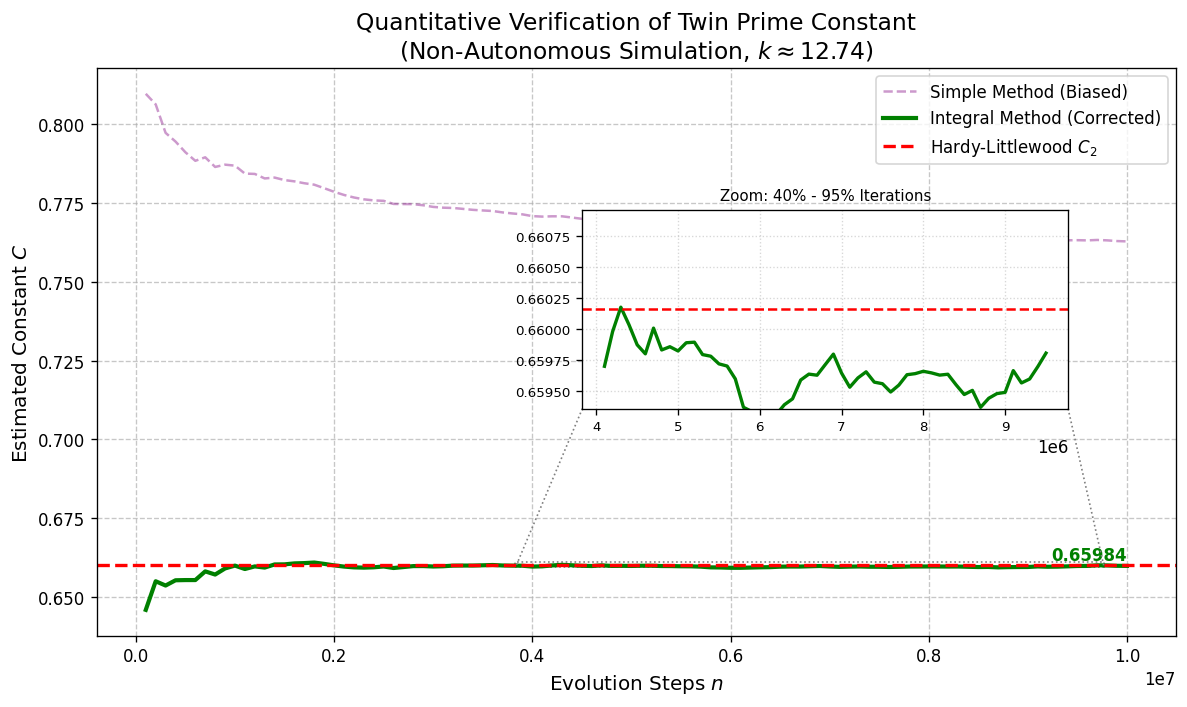

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_perfect_convergence(max_iter=10000000, scale_factor=12.7374): # 更新了k值
    print(f"开始运行[积分法修正]的非自治混沌实验，目标迭代: {max_iter}...")
    
    # 1. 基础参数
    u = 1.543689012692076 
    x = 0.1
    for _ in range(10000): x = 1 - u * x**2
    
    C2_REAL = 0.6601618158
    
    # 2. 辅助函数
    def Li2_integral(limit):
        val, _ = quad(lambda t: 1/np.log(t)**2, 2, limit)
        return val

    # 3. 模拟
    lrl_weighted_count = 0
    history = [0, 0, 0]
    
    checkpoints = np.linspace(100000, max_iter, 100).astype(int) # 增加点密度让图更滑
    checkpoints = np.unique(checkpoints)
    
    x_vals = []
    c_estimates_simple = []
    c_estimates_integral = []
    
    current_iter = 0
    
    for target in checkpoints:
        steps = target - current_iter
        
        for i in range(steps):
            current_n = current_iter + i + 1
            if current_n < 3: continue
            
            x = 1 - u * x**2
            is_L = 1 if x < 0 else 0
            history.pop(0)
            history.append(is_L)
            
            if history == [1, 0, 1]:
                weight = scale_factor / (np.log(current_n)**2)
                lrl_weighted_count += weight
        
        current_iter = target
        
        # 计算
        # 简单法
        approx_li2 = target / (np.log(target)**2)
        c_sim = lrl_weighted_count / (2 * approx_li2)
        
        # 积分法
        real_li2 = Li2_integral(target)
        c_int = lrl_weighted_count / (2 * real_li2)

        c_estimates_simple.append(c_sim)
        c_estimates_integral.append(c_int)
        x_vals.append(target)

    # 4. 绘图
    fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
    
    # 主图曲线
    ax.plot(x_vals, c_estimates_simple, '--', color='purple', alpha=0.4, label='Simple Method (Biased)')
    ax.plot(x_vals, c_estimates_integral, '-', linewidth=2.5, color='green', label='Integral Method (Corrected)')
    ax.axhline(y=C2_REAL, color='red', linestyle='--', linewidth=2, label='Hardy-Littlewood $C_2$')
    
    # 设置主图标签
    ax.set_title(f'Quantitative Verification of Twin Prime Constant\n(Non-Autonomous Simulation, $k\\approx{scale_factor:.2f}$)', fontsize=14)
    ax.set_xlabel('Evolution Steps $n$', fontsize=12)
    ax.set_ylabel('Estimated Constant $C$', fontsize=12)
    ax.legend(loc='upper right') # 图例放右上
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

    # --- 核心修改：子图位置与范围 ---
    
    # 1. 创建子图 (Inset Axes)
    # [x, y, width, height] 是相对于主图坐标系的比例 (0到1)
    # x=0.45: 从横向45%的位置开始（中间偏右）
    # y=0.40: 从纵向40%的位置开始（比之前高了，不在角落）
    # width=0.45: 宽度占45%
    # height=0.35: 高度占35%
    ax_ins = ax.inset_axes([0.45, 0.40, 0.45, 0.35])
    
    # 2. 截取数据范围 (0.4 到 0.9)
    # 找到对应的索引位置
    start_ratio = 0.4
    end_ratio = 0.95 # 稍微多一点点到0.95，包含更多信息
    
    # 为了防止索引越界，做个简单的映射
    idx_start = int(len(x_vals) * start_ratio)
    idx_end = int(len(x_vals) * end_ratio)
    
    x_zoom = x_vals[idx_start:idx_end]
    y_zoom = c_estimates_integral[idx_start:idx_end]
    
    # 3. 在子图中绘图
    ax_ins.plot(x_zoom, y_zoom, '-', color='green', linewidth=2)
    ax_ins.axhline(y=C2_REAL, color='red', linestyle='--', linewidth=1.5)
    
    # 4. 设置子图的 Y 轴范围 (这一步很关键，要放大看波动)
    # 计算这部分数据的均值，然后上下各扩一点点
    y_center = np.mean(y_zoom)
    y_window = 0.0008 # 窗口极小，体现高精度
    ax_ins.set_ylim(C2_REAL - y_window, C2_REAL + y_window)
    
    # 5. 美化子图
    ax_ins.set_title(f"Zoom: {int(start_ratio*100)}% - {int(end_ratio*100)}% Iterations", fontsize=9)
    ax_ins.tick_params(axis='both', which='major', labelsize=8)
    ax_ins.grid(True, linestyle=':', alpha=0.5)
    
    # 6. 添加连接线 (Mark Inset) - 让视觉上知道子图是哪里的放大
    # loc1=2 (左上), loc2=4 (右下) 连接主图对应区域
    mark_inset(ax, ax_ins, loc1=3, loc2=4, fc="none", ec="0.5", linestyle=":")
    
    # 显示最终数值
    final_val = c_estimates_integral[-1]
    ax.text(x_vals[-1], final_val + 0.002, f"{final_val:.5f}", color='green', fontweight='bold', ha='right')
    
    plt.tight_layout()
    plt.show()

# 运行
plot_perfect_convergence()